In [1]:
%matplotlib inline
import sys, os
os.environ['COBAYA_NOMPI'] = 'True'
sys.path.append('/global/project/projectdirs/desi/users/jderose/CobayaLSS/')
sys.path.append('/global/project/projectdirs/desi/users/jderose/CobayaLSS/lss_likelihood/')

import numpy as np
import matplotlib.pyplot as plt
from cobaya.model import get_model
from cobaya.yaml import yaml_load
import yaml
import h5py
# https://matplotlib.org/users/customizing.html
plt.rcParams['figure.figsize']        = 8., 6.
plt.rcParams['figure.dpi']            = 100
plt.rcParams['figure.subplot.left']   = 0.125
plt.rcParams['figure.subplot.right']  = 0.9
plt.rcParams['figure.subplot.bottom'] = 0.125
plt.rcParams['figure.subplot.top']    = 0.9
plt.rcParams['axes.labelsize']        = 18
plt.rcParams['axes.titlesize']        = 18
plt.rcParams['xtick.top']             = True
plt.rcParams['xtick.bottom']          = True
plt.rcParams['ytick.left']            = True
plt.rcParams['ytick.right']           = True
plt.rcParams['xtick.direction']       = 'in'
plt.rcParams['ytick.direction']       = 'in'
plt.rcParams['xtick.labelsize']       = 18
plt.rcParams['ytick.labelsize']       = 18
plt.rcParams['xtick.major.pad']       = 6.
plt.rcParams['xtick.minor.pad']       = 6.
plt.rcParams['ytick.major.pad']       = 6.
plt.rcParams['ytick.minor.pad']       = 6.
plt.rcParams['xtick.major.size']      = 6. # major tick size in points
plt.rcParams['xtick.minor.size']      = 3. # minor tick size in points
plt.rcParams['ytick.major.size']      = 6. # major tick size in points
plt.rcParams['ytick.minor.size']      = 3. # minor tick size in points
plt.rcParams['text.usetex']           = True
plt.rcParams['font.family']           = 'serif'
plt.rcParams['font.serif']            = 'Computer Modern Roman Bold'
plt.rcParams['font.size']             = 18

colors = ['#8d598f', '#cd9b00', '#de2d26', '#004d00', '#3182bd'][::-1]


In [17]:
info_txt='/global/project/projectdirs/desi/users/jderose/CobayaLSS/configs/example_config.yaml'

# this specifies the likelihood that you're computing, including which theory modules (e.g. anzu) that you want to use.
# In particular, the block in the file below that reads:
# likelihood:
#   lss_likelihood.wl_x_rsd.HarmonicSpaceWLxRSD :
#     datavector_info_filename : /global/project/projectdirs/desi/users/jderose/CobayaLSS/unit_redmagic_rs_data.yaml
#     zmin_proj: 0.0
#     zmax_proj: 2.0
#     nz_proj: 20
#     heft: True
#     halofit_pmm: False
#
# tells us that we want to use the data contained in the `datavector_info_filename` field to compute our likelihood. 

In [3]:
# Let's look at what's in this file
!cat /global/project/projectdirs/desi/users/jderose/CobayaLSS/unit_redmagic_rs_data.yaml

spectra_filename : /global/project/projectdirs/desi/users/jderose/CobayaLSS/data/windowed_cmbwl_x_projgal.txt
covariance_filename : /global/project/projectdirs/desi/users/jderose/CobayaLSS/data/windowed_cmbwl_x_projgal_dummy_cov.txt
nz_d : /project/projectdirs/desi/users/jderose/CobayaLSS/data/wl_x_rsd_nz.txt
z_fid: [0.5924]
chiz_fid: [1519.46]
hz_fid: [1.389]

In [4]:
# In this example, we're just computing one lens sample angular auto spectrum, and it cross spectrum with CMB lensing.
# `spectra_filename` contains links to the actual spectra functions that we wish to compare our predictions to
# `covariance_filename` contains the covariance
# `nz_d` contains the lens number density. In the case where we're actually computing galaxy-galaxy lensing statistics, we would 
# also require `nz_s` containing source number densities as well.

In [5]:
# these are not real data vectors, just basic examples of 
spec_dt = np.dtype([('spectrum_type', 'U10'), ('zbin0', np.int),
                    ('zbin1', np.int), ('separation', np.float), ('value', np.float)])

cov_dt = np.dtype([('spectrum_type0','U10'), ('spectrum_type1','U10'), ('zbin00', np.int),
       ('zbin01', np.int), ('zbin10', np.int), ('zbin11', np.int), 
       ('separation0', np.float), ('separation1', np.float), ('value', np.float)])

#spectra = np.genfromtxt('/project/projectdirs/desi/users/jderose/CobayaLSS/data/rs_spectra.txt', dtype=spec_dt)
spectra = np.genfromtxt('/global/project/projectdirs/desi/users/jderose/CobayaLSS/data/windowed_cmbwl_x_projgal.txt', dtype=spec_dt)
cov = np.genfromtxt('/global/project/projectdirs/desi/users/jderose/CobayaLSS/data/windowed_cmbwl_x_projgal_dummy_cov.txt', dtype=cov_dt)
nz = np.genfromtxt('/project/projectdirs/desi/users/jderose/CobayaLSS/data/wl_x_rsd_nz.txt', dtype=None, names=True)

In [6]:
print('spectrum format')
print(spectra.dtype)

print('cov format')
print(cov.dtype)

print('nz format')
print(nz.dtype)

spectrum format
[('spectrum_type', '<U10'), ('zbin0', '<i8'), ('zbin1', '<i8'), ('separation', '<f8'), ('value', '<f8')]
cov format
[('spectrum_type0', '<U10'), ('spectrum_type1', '<U10'), ('zbin00', '<i8'), ('zbin01', '<i8'), ('zbin10', '<i8'), ('zbin11', '<i8'), ('separation0', '<f8'), ('separation1', '<f8'), ('value', '<f8')]
nz format
[('z', '<f8'), ('nz0', '<f8')]


Text(0, 0.5, '$C(\\ell)$')

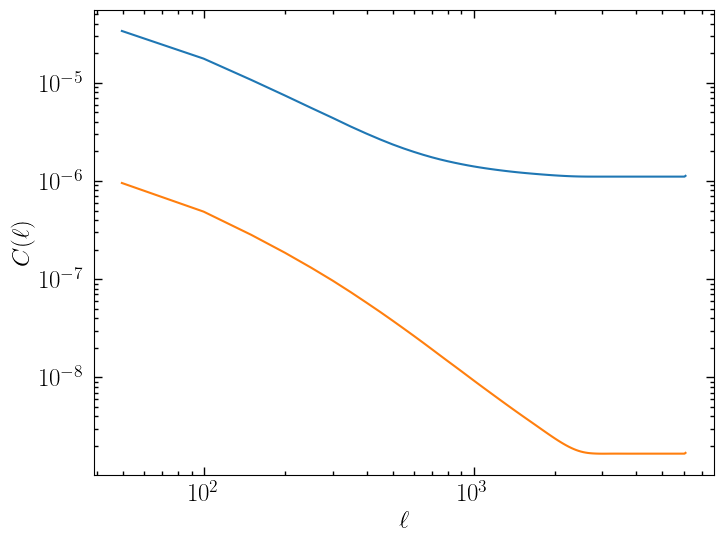

In [7]:
# lens-lens auto correlation
c_dd = spectra[(spectra['spectrum_type'] == 'c_dd') & (spectra['zbin0']==0) & (spectra['zbin1']==0)]

# lens-cmbkappa cross correlation
c_dcmbk = spectra[(spectra['spectrum_type'] == 'c_dcmbk') & (spectra['zbin0']==0) & (spectra['zbin1']==0)]

plt.loglog(c_dd['separation'], c_dd['value'])
plt.loglog(c_dcmbk['separation'], c_dcmbk['value'])
plt.xlabel(r'$\ell$')
plt.ylabel(r'$C(\ell)$')

Text(0, 0.5, '$n(z)$')

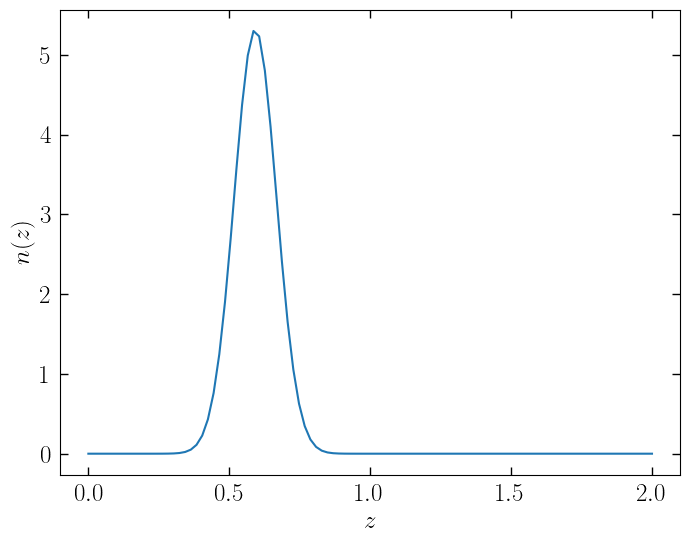

In [8]:
#if there were more lens bins, would have extra fields called nz1, nz2, etc.
plt.plot(nz['z'], nz['nz0'])
plt.xlabel(r'$z$')
plt.ylabel(r'$n(z)$')

In [9]:
#now lets load this model
with open(info_txt, 'rb') as fp:
    info = yaml.load(fp)
    
info['packages_path'] = '/global/project/projectdirs/desi/users/jderose/CobayaLSS/'
info['debug'] = False
info['stop_at_error'] = True

model = get_model(info)



<ipython-input-9-8cad666a20b3>:3: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  info = yaml.load(fp)


[model] *WARNING* Ignored blocks/options: ['sampler', 'output', 'stop_on_error', 'emulate']
[CAMB] Importing *auto-installed* CAMB (but defaulting to *global*).
[camb] Initialized!


/global/homes/j/jderose/.conda/envs/cobaya/lib/python3.8/site-packages/anzu-1.0-py3.8.egg/anzu/emu_funcs.py:155: UserWarning: kecleft and extrap are both set. Setting extrap to False.
  warnings.warn(
/global/homes/j/jderose/.conda/envs/cobaya/lib/python3.8/site-packages/anzu-1.0-py3.8.egg/anzu/emu_funcs.py:224: RuntimeWarning: invalid value encountered in log10
  simoverlpt = np.log10(simoverlpt)
/global/project/projectdirs/desi/users/jderose/CobayaLSS/lss_likelihood/wl_x_rsd.py:93: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  datavector_info = yaml.load(fp)
/global/project/projectdirs/desi/users/jderose/CobayaLSS/lss_likelihood/wl_x_rsd.py:264: UserWarning: No scale cuts specified for any spectra!
  warnings.warn('No scale cuts specified for any spectra!', UserWarning)


In [10]:
bounds = model.prior.bounds()
params = model.prior.params


In [11]:
#parameters we're sampling over and their bounds, as defined in the config file
dict(zip(params,bounds))

{'logA': array([3.   , 3.179]),
 'ns': array([0.927, 0.997]),
 'H0': array([61.6, 74.7]),
 'w': array([-1.39 , -0.565]),
 'ombh2': array([0.0206, 0.0237]),
 'omch2': array([0.1012, 0.1317]),
 'b1_0': array([0., 3.]),
 'b2_0': array([-5.,  5.]),
 'bk_0': array([-100.,  100.]),
 'sn_0': array([-5000.,  5000.])}

In [12]:
#now we can evaluate the model at some reference values for the parameters
unit_params = [3.064, 0.9667, 67.74, -1, 0.02230, 0.1188, 1, 0, 0, 1000]
pars = dict(zip(params, unit_params))
print(pars)

{'logA': 3.064, 'ns': 0.9667, 'H0': 67.74, 'w': -1, 'ombh2': 0.0223, 'omch2': 0.1188, 'b1_0': 1, 'b2_0': 0, 'bk_0': 0, 'sn_0': 1000}


In [13]:
model.logposterior(pars)

LogPosterior(logpost=-6.644084893346942, logpriors=[-6.644084184812056], loglikes=array([-7.08534886e-07]), derived=[2.1413038238853928e-09, 0.30749398806757705, 0.1411, 0.6924148566859444, 0.2453573220513785, 0.24668369813315752, 2.5984515944044935, 10.0, 0.8277003351138936, 1.0056585143364587, 0.45897755234660065, 0.6163569370803219, 2.141303823885393, 1.8615601137857205, 13.81478494957316, 147.5024254661745])

In [14]:
#Lets take a look at the predictions
like = model.likelihood['lss_likelihood.wl_x_rsd.HarmonicSpaceWLxRSD']

In [15]:
#this contains all the info about the model predictions and the actual data we looked at earlier
like.spectrum_info

{'c_dcmbk': {'bins0': array([0]),
  'bins1': array([0]),
  'n_dv_per_bin': 122,
  'separation': array([  49.5,   99.5,  149.5,  199.5,  249.5,  299.5,  349.5,  399.5,
          449.5,  499.5,  549.5,  599.5,  649.5,  699.5,  749.5,  799.5,
          849.5,  899.5,  949.5,  999.5, 1049.5, 1099.5, 1149.5, 1199.5,
         1249.5, 1299.5, 1349.5, 1399.5, 1449.5, 1499.5, 1549.5, 1599.5,
         1649.5, 1699.5, 1749.5, 1799.5, 1849.5, 1899.5, 1949.5, 1999.5,
         2049.5, 2099.5, 2149.5, 2199.5, 2249.5, 2299.5, 2349.5, 2399.5,
         2449.5, 2499.5, 2549.5, 2599.5, 2649.5, 2699.5, 2749.5, 2799.5,
         2849.5, 2899.5, 2949.5, 2999.5, 3049.5, 3099.5, 3149.5, 3199.5,
         3249.5, 3299.5, 3349.5, 3399.5, 3449.5, 3499.5, 3549.5, 3599.5,
         3649.5, 3699.5, 3749.5, 3799.5, 3849.5, 3899.5, 3949.5, 3999.5,
         4049.5, 4099.5, 4149.5, 4199.5, 4249.5, 4299.5, 4349.5, 4399.5,
         4449.5, 4499.5, 4549.5, 4599.5, 4649.5, 4699.5, 4749.5, 4799.5,
         4849.5, 4899.5, 4949.

<ipython-input-16-9b757870ef4d>:16: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  plt.xlim([0,1000])


(38.9108526082757, 1000)

[matplotlib.texmanager] No LaTeX-compatible font found for the serif font family in rcParams. Using default.
[matplotlib.texmanager] No LaTeX-compatible font found for the serif font family in rcParams. Using default.
[matplotlib.texmanager] No LaTeX-compatible font found for the serif font family in rcParams. Using default.
[matplotlib.texmanager] No LaTeX-compatible font found for the serif font family in rcParams. Using default.
[matplotlib.texmanager] No LaTeX-compatible font found for the serif font family in rcParams. Using default.
[matplotlib.texmanager] No LaTeX-compatible font found for the serif font family in rcParams. Using default.
[matplotlib.texmanager] No LaTeX-compatible font found for the serif font family in rcParams. Using default.
[matplotlib.texmanager] No LaTeX-compatible font found for the serif font family in rcParams. Using default.
[matplotlib.texmanager] No LaTeX-compatible font found for the serif font family in rcParams. Using default.
[matplotlib.texmana

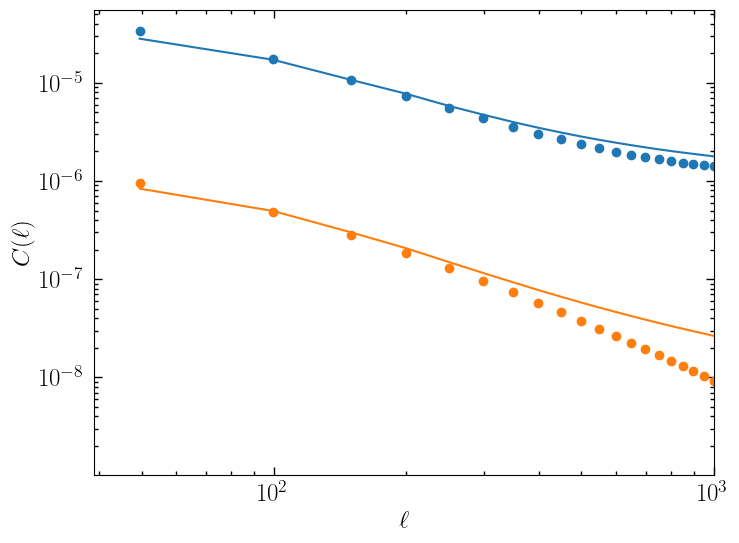

In [16]:
#Just as an example, we can plot the model predictions against the data. These aren't really meant to match since I haven't tuned the bias parameters at all.
# lens-lens auto correlation
c_dd = spectra[(spectra['spectrum_type'] == 'c_dd') & (spectra['zbin0']==0) & (spectra['zbin1']==0)]

# lens-cmbkappa cross correlation
c_dcmbk = spectra[(spectra['spectrum_type'] == 'c_dcmbk') & (spectra['zbin0']==0) & (spectra['zbin1']==0)]

plt.loglog(c_dd['separation'], c_dd['value'], ls='', marker='o')
plt.loglog(c_dcmbk['separation'], c_dcmbk['value'], ls='', marker='o')
plt.gca().set_prop_cycle(None)
plt.loglog(like.spectrum_info['c_dd']['separation'], like.spectrum_info['c_dd']['0_model'])
plt.loglog(like.spectrum_info['c_dcmbk']['separation'], like.spectrum_info['c_dcmbk']['0_model'])

plt.xlabel(r'$\ell$')
plt.ylabel(r'$C(\ell)$')
plt.xlim([0,1000])